<a href="https://colab.research.google.com/github/tanumalik12/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings('ignore')

In [5]:
! pip install catboost

  Using cached catboost-1.2.2-cp310-cp310-manylinux2014_x86_64.whl (98.7 MB)


In [6]:
from catboost import CatBoostClassifier

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('ggplot')
plt.style.use('dark_background')
sns.set_theme(style="whitegrid", palette="pastel")
sns.set(rc={'figure.figsize':(10,4)})

**Loading the dataset**

In [8]:
data = pd.read_csv('chat_dataset.csv')
data

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative
...,...,...
579,I have to cancel my vacation plans because I c...,negative
580,My computer crashed and I lost all my importan...,negative
581,I got into a car accident and my car is totale...,negative
582,I have a cold and can't stop coughing. it's re...,negative


seeing the sentiment column distribution through matplotlib library

<Axes: >

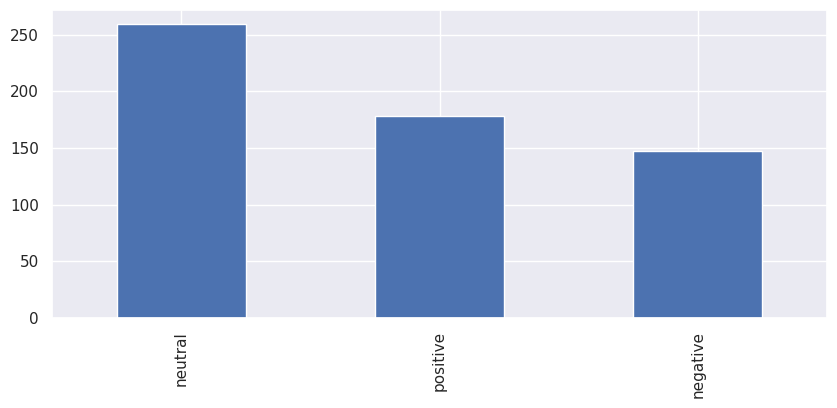

In [9]:
data.sentiment.value_counts().plot(kind = 'bar')

seeing same with seaborn library

<Axes: xlabel='sentiment', ylabel='count'>

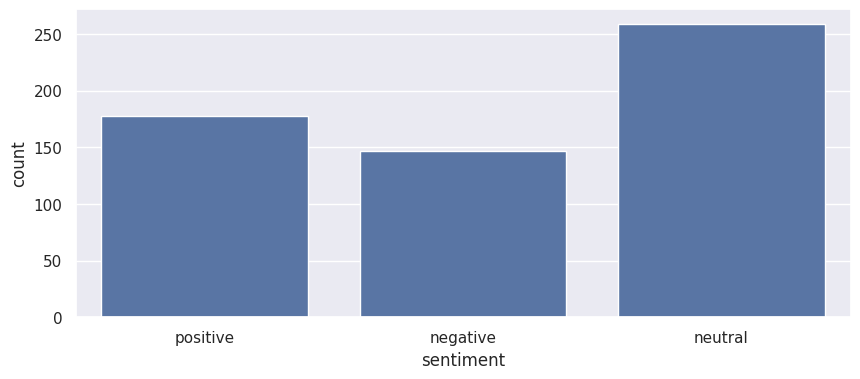

In [10]:
sns.countplot(data = data, x = 'sentiment')

checking the dtypes and total row counts

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    584 non-null    object
 1   sentiment  584 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB


Checking if any Nan value is present

In [12]:
data.isna().sum()

message      0
sentiment    0
dtype: int64

Below are some of the helper functions

In [25]:
#### HTML Tags removal #########
import nltk
import nltk.corpus
! pip install emoji

import re
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)


def clean_re(text):
    regex = re.compile('[^a-z\s]')
    return regex

#### Remove links ##########
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)


#### Remove Punctuation ########
import string
exclude = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))


from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)


### Remove Emoji
import re
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


### Replace Emoji with words
import emoji
def demojize(text):
    return emoji.demojize(text)


### Tokenisation with NLTK
from nltk.tokenize import word_tokenize,sent_tokenize
def word_tokenize_nltk(text):
    return word_tokenize(text)

#### Tokenisation with spacy
import spacy
nlp = spacy.load('en_core_web_sm')
def word_tokenize_spacy(text):
    return nlp(text)

### Stemming
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(token.text) for token in nlp(text)])


###### Lemmatization
import spacy
nlp = spacy.load("en_core_web_sm")
def lemmatize_words(text):
    doc = nlp(text)
    return " ".join([token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 5.9 MB/s eta 0:00:00


**Creating a function for preprocessing**

In [26]:
############ Main Func ###########

def preprocess_inputs(df):
    df = df.copy()
    df['message'] = df['message'].str.lower()
    df['message'] = df['message'].apply(remove_html_tags)

    df['message'] = df['message'].apply(remove_url)
    df['message'] = df['message'].apply(remove_punc)
    df['message'] = df['message'].apply(remove_stopwords)
    df['message'] = df['message'].apply(demojize)
    df['message'] = df['message'].apply(word_tokenize_spacy)
    df['message'] = df['message'].apply(lemmatize_words)
#     df['message'] = df['message'].apply(remove_emoji)

    return df

**Function call**

In [27]:
X = preprocess_inputs(data)
X

,message,sentiment
0,really enjoy movie,positive
1,food terrible,negative
2,I m sure feel,neutral
3,service excellent,positive
4,bad experience,negative
...,...,...
579,cancel vacation plan can not get time work : d...,negative
580,computer crash lose important file : face_scre...,negative
581,get car accident car total : pensive_face::aut...,negative
582,cold can not stop cough really hard sleep : fa...,negative


Below, I realise ':', 'I', and 'm' are words most used, which I am not interested in

In [28]:
words = []
for text in X['message']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(23))
top_words


{':': 514,
 'I': 216,
 'm': 213,
 'feel': 55,
 'not': 36,
 'sure': 34,
 'average': 31,
 'today': 28,
 'love': 27,
 'service': 26,
 'do': 26,
 'bit': 25,
 'get': 25,
 'product': 24,
 'hotel': 24,
 'food': 20,
 'work': 19,
 'time': 19,
 'new': 19,
 'movie': 18,
 'go': 18,
 'try': 18,
 'enjoy': 15}

So, converting the dict to a list and back to a dict while removing the first 3 elements is what I am going with

In [29]:
top_words = dict(list(top_words.items())[3:])

Text(0, 0.5, 'Frequency')

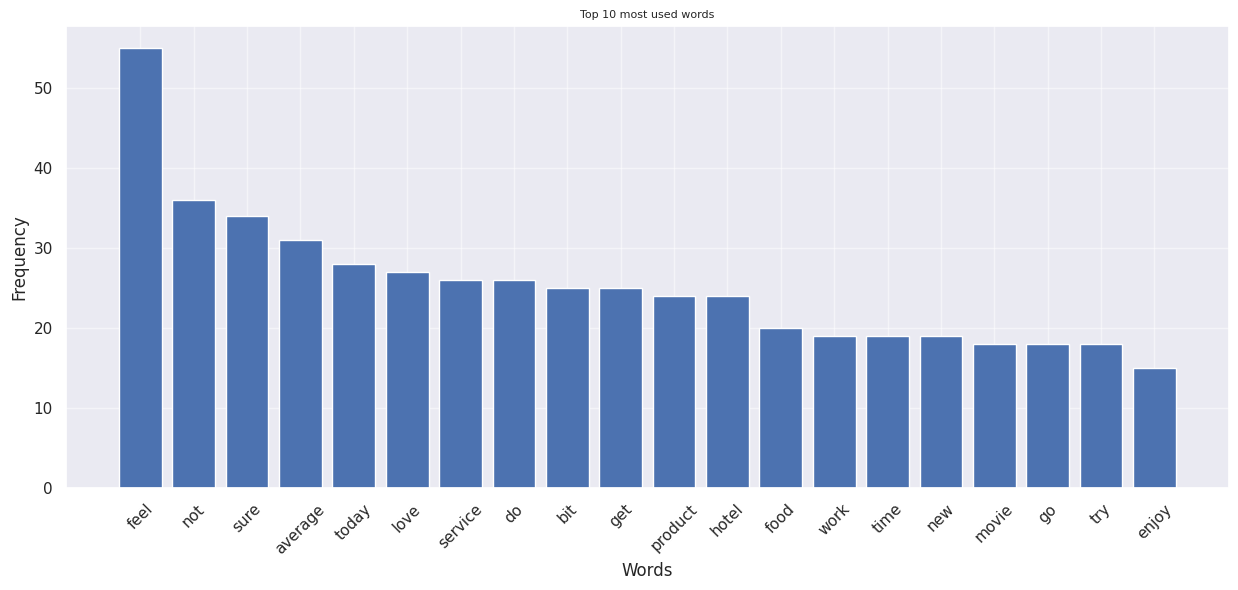

In [30]:
# Figure Size
plt.figure(figsize = (15, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)

# Title
plt.title('Top 10 most used words', fontsize = 8)
plt.xticks(rotation = 45, ha = 'center')
plt.xlabel('Words')
plt.ylabel('Frequency')


In [31]:
X.loc[X.message.str.contains(':')]

,message,sentiment
327,hey what s : grinning_face :,neutral
328,I m feel soso : confused_face :,neutral
329,thank help : folded_hands :,neutral
330,I m sure : confused_face :,neutral
331,reschedule meeting : calendar :,neutral
...,...,...
579,cancel vacation plan can not get time work : d...,negative
580,computer crash lose important file : face_scre...,negative
581,get car accident car total : pensive_face::aut...,negative
582,cold can not stop cough really hard sleep : fa...,negative


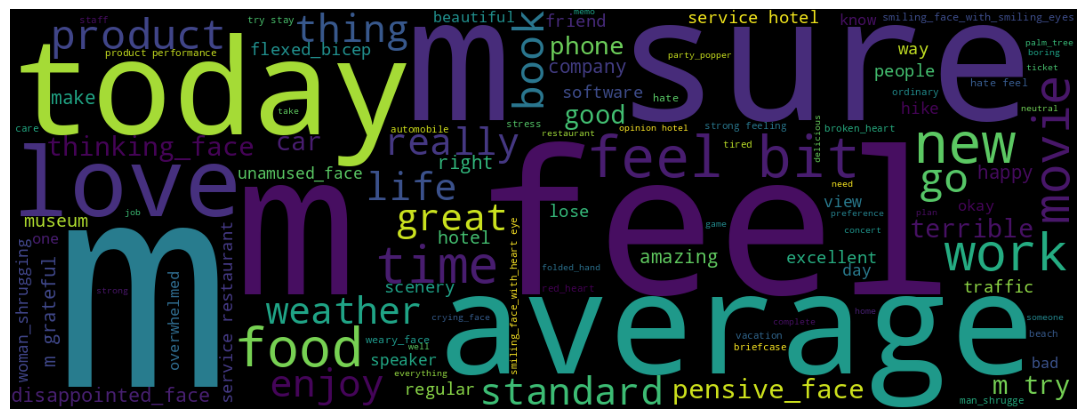

In [32]:
text = ' '.join(caption for caption in X['message'])

wordcloud = WordCloud(width = 1200, height = 450, background_color = 'black',
                min_font_size = 10).generate(text)

plt.figure(figsize = (14, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [33]:
X['sentiment'] = X['sentiment'].map({'neutral' : 0, 'positive' : 1, 'negative' : 2})
X['sentiment']


0      1
1      2
2      0
3      1
4      2
      ..
579    2
580    2
581    2
582    2
583    2
Name: sentiment, Length: 584, dtype: int64

In [34]:
X['message']

0                                     really enjoy movie
1                                          food terrible
2                                          I m sure feel
3                                      service excellent
4                                         bad experience
                             ...                        
579    cancel vacation plan can not get time work : d...
580    computer crash lose important file : face_scre...
581    get car accident car total : pensive_face::aut...
582    cold can not stop cough really hard sleep : fa...
583    find ex date someone new feel heartbroken : br...
Name: message, Length: 584, dtype: object

In [35]:
x = np.array(X['message'])
# x

In [36]:
x = np.array(X['message'])
y = np.array(X['sentiment'])

cv = CountVectorizer()
x = cv.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

**Training various models to see the performence**

In [37]:
######## Defining Models ###################

models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier(),
    "                               XGBoost": XGBClassifier(eval_metric='mlogloss'),
#     "                              LightGBM": LGBMClassifier(),
    "                              CatBoost": CatBoostClassifier(verbose=0)
}

In [38]:
############# Running all the models in loop ###################

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                        Neural Network trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
                              CatBoost trained.


In [39]:
############## Accuracy Score #################################

asdf = pd.DataFrame()
for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))
    asdf['name'] = name
    asdf['Acc score'] = model.score(X_test, y_test)

                   Logistic Regression: 83.56%
                   K-Nearest Neighbors: 54.79%
                         Decision Tree: 76.71%
Support Vector Machine (Linear Kernel): 85.62%
   Support Vector Machine (RBF Kernel): 77.40%
                        Neural Network: 82.88%
                         Random Forest: 77.40%
                     Gradient Boosting: 80.82%
                               XGBoost: 76.71%
                              CatBoost: 82.19%


In [40]:
asdf = pd.DataFrame(columns=['name', 'Acc score'])
for name, model in models.items():
    score = model.score(X_test, y_test)
#     print(name + ": {:.2f}%".format(score * 100))
    asdf.loc[len(asdf)] = [name, score]
asdf = asdf.sort_values('Acc score', ascending = False)
asdf


,name,Acc score
3,Support Vector Machine (Linear Kernel),0.856164
0,Logistic Regression,0.835616
5,Neural Network,0.828767
9,CatBoost,0.821918
7,Gradient Boosting,0.808219
4,Support Vector Machine (RBF Kernel),0.773973
6,Random Forest,0.773973
2,Decision Tree,0.767123
8,XGBoost,0.767123
1,K-Nearest Neighbors,0.547945


In [41]:
asdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 3 to 1
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       10 non-null     object 
 1   Acc score  10 non-null     float64
dtypes: float64(1), object(1)
memory usage: 240.0+ bytes


**Checking metrics for the best performer**

In [42]:
svc = SVC()
svc.fit(X_test, y_test)
y_pred = svc.predict(X_test)

**Confusion Matrix**

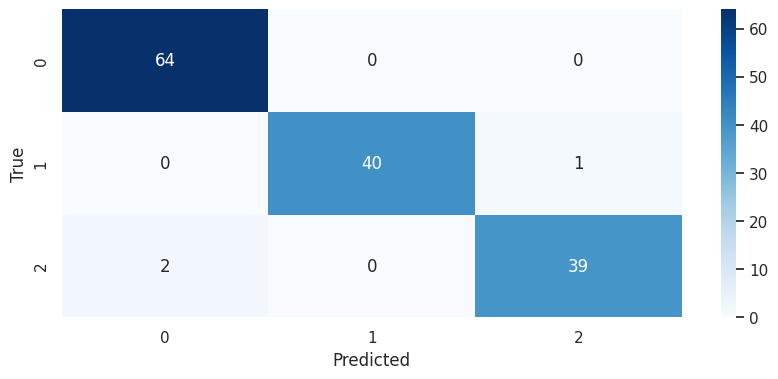

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Class Report**

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.98      0.99        41
           2       0.97      0.95      0.96        41

    accuracy                           0.98       146
   macro avg       0.98      0.98      0.98       146
weighted avg       0.98      0.98      0.98       146

